In [44]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset

In [45]:
# Load data
X, Y = load_planar_dataset()

In [46]:
# Check how many datapoints and features we have.
X_shape = X.shape
Y_shape = Y.shape
m = X_shape[1]
print(f"Shape of X: {X_shape} \nShape of Y: {Y_shape} \nNumber of training examples: {m}")

Shape of X: (2, 400) 
Shape of Y: (1, 400) 
Number of training examples: 400


Accuracy of logistic regression: 47.0%


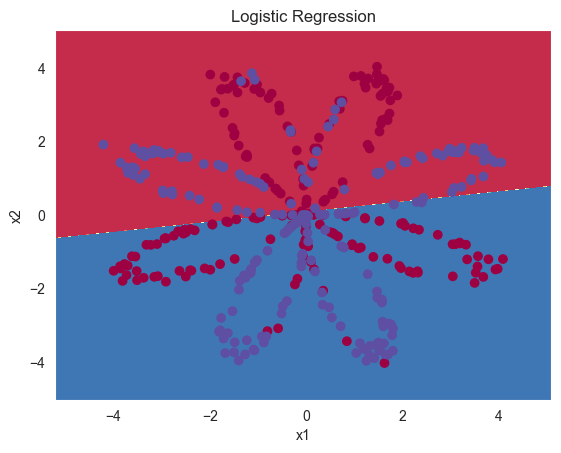

In [47]:
# Let's see how Logistic regression performs first.
LR = LogisticRegressionCV()
LR.fit(X.T, Y.ravel())

# Make predictions using our trained LR model
LR_predictions = LR.predict(X.T)

# Obtain the accuracy
accuracy = accuracy_score(Y.ravel(), LR_predictions)

# Print Accuracy
print(f"Accuracy of logistic regression: {accuracy:.1%}")

# Plot the decision boundary.
plot_decision_boundary(lambda x: LR.predict(x), X, Y)
plt.title("Logistic Regression")
plt.show()

# We can see that the data is not linearly separable, so we can expect LR to perform poorly.

In [48]:
# General path to build a neural network is: define NN structure, initialize parameters, loop: forward prop, compute loss, back prop, update weights.
# Let's build a small NN with one input layer, one hidden layer, and one output layer

# NN structure
def layer_sizes(X, Y):
    n_x = X.shape[0]   # The number of units in the input layer is equal to the number of features.
    n_h = 4            # Let's use a hidden layer of 4 units.
    n_y = Y.shape[0]   # The number of units in the output layer is the rows of Y

    return n_x, n_h, n_y

In [49]:
# Initialize parameters of the NN
def initialize_parameters(n_x, n_h, n_y):

    # We DO NOT initialize to the weights to zeros, since this will make our NN output a linear function of the inputs.
    # We also make the random numbers small, since this will make the gradients larger in back prop, speeding up GD.
    W1 = np.random.randn(n_h, n_x) * 0.01
    W2 = np.random.randn(n_y, n_h) * 0.01
    b1 = np.zeros((n_h, 1))
    b2 = np.zeros((n_y, 1))

    # Return the initialized parameters.
    parameters = {
        "W1": W1,
        "W2": W2,
        "b1": b1,
        "b2": b2,
    }
    return parameters

In [50]:
# Propagating forward in the computation graph
def forward_propagation(parameters, X):

    # Extract parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1     # Shape (n_h, m)
    A1 = np.tanh(Z1)            # Shape (n_h, m)
    Z2 = np.dot(W2, A1) + b2    # Shape (n_y, m)
    A2 = sigmoid(Z2)            # Shape (n_y, m)

    cache = {                   # Values needed for back prop
        "Z1": Z1,
        "A1": A1,
        "Z2": Z2,
        "A2": A2,
    }
    return cache, A2 # return the predictions from forward prop and the cache for back prop

In [51]:
# Used to compute cost
def compute_cost(A2, Y):

    # number of predictions, one for each datapoint
    m = Y.shape[1]

    # compute cost
    cost = -(1/m) * np.sum(Y * np.log(A2) + (1 - Y) * np.log(1 - A2))

    # return the cost as a float.
    return float(cost)

In [52]:
def backward_propagation(parameters, cache, X, Y):

    W2 = parameters["W2"]       # Extract W2

    A1 = cache["A1"]            # Extract A1
    A2 = cache["A2"]            # Extract A2

    # Back prop for output layer
    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

    # Back prop for hidden layer
    dZ1 = np.dot(W2.T, dZ2) * (1 - np.power(A1, 2)) # tanh'(x) =  1 - tanh(x)^2 is the derivative of the tanh function
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

    # Return the gradients we will use for gradient descent
    grads = {"dW1": dW1,
             "db1": db1,
             "dW2": dW2,
             "db2": db2}

    return grads

In [53]:
# Perform gradient descent
def update_parameters(parameters, grads, learning_rate = 1.2):

    # Extract parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    # Extract gradients
    DW1 = grads["dW1"]
    DW2 = grads["dW2"]
    db1 = grads["db1"]
    db2 = grads["db2"]

    # perform gradient descent
    W1 = W1 - learning_rate * DW1
    b1 = b1 - learning_rate * db1
    W2 = W2 - learning_rate * DW2
    b2 = b2 - learning_rate * db2

    # Dictionary of updated parameters
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    return parameters

In [54]:
# Combine everything into our final NN model
def nn_model(X, Y, n_h, max_iter=1000, print_cost=False):

    # define NN structure
    n_x = X.shape[0]
    n_y = Y.shape[0]

    # Initialize parameters
    parameters = initialize_parameters(n_x, n_h, n_y)

    for i in range(max_iter):

        # Perform forward propagation
        cache, A2 = forward_propagation(parameters, X)

        # Calculate cost
        cost = compute_cost(A2, Y)

        # Perform back propagation
        grads = backward_propagation(parameters, cache,  X, Y)

        # Perform gradient descent
        parameters = update_parameters(parameters, grads)

        # show the cost every 1000 iteration if print cost is True
        if print_cost and i % 1000 == 0:
            print(i, cost)

    return parameters


In [55]:
# Get the predictions
def predict(parameters, X):
    # Run forward prop with our learned parameters.
    cache, A2 = forward_propagation(parameters, X)

    # A2 > 05 creates a boolean array of size A2 that is true if the condition is met and false otherwise.
    # astype(int) converts the true and false values to 0 and 1 respectively.
    predictions = (A2 > 0.5).astype(int)

    return predictions

0 0.6931125167719424
1000 0.28257810627095964
2000 0.2697771489412197
3000 0.26231806209753844
4000 0.24122763763977215
5000 0.22602306763242705
6000 0.2216209603140178
7000 0.21890721724721857
8000 0.216884894610155
9000 0.2152597281460529


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

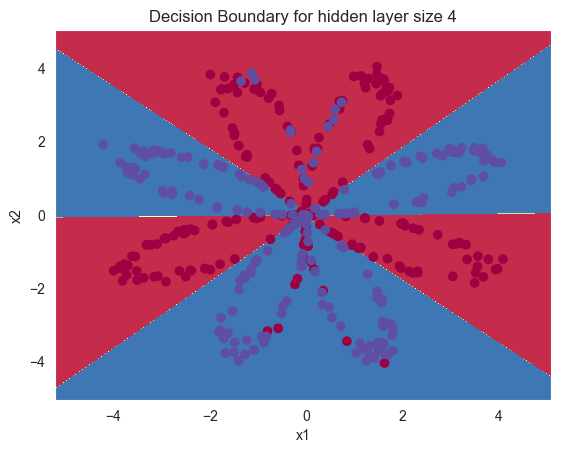

In [56]:
# run our model.
parameters = nn_model(X, Y, n_h = 4, max_iter = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [57]:
# Calculate accuracy using a 4 unit hidden layer.
predictions = predict(parameters, X)
accuracy = accuracy_score(Y.ravel(), predictions.ravel())
print(f"accuracy = {100 * accuracy:.1f}%")

accuracy = 90.8%


Accuracy for 1 hidden units: 67.5 %
Accuracy for 2 hidden units: 67.25 %
Accuracy for 3 hidden units: 90.75 %
Accuracy for 4 hidden units: 90.75 %
Accuracy for 5 hidden units: 91.0 %


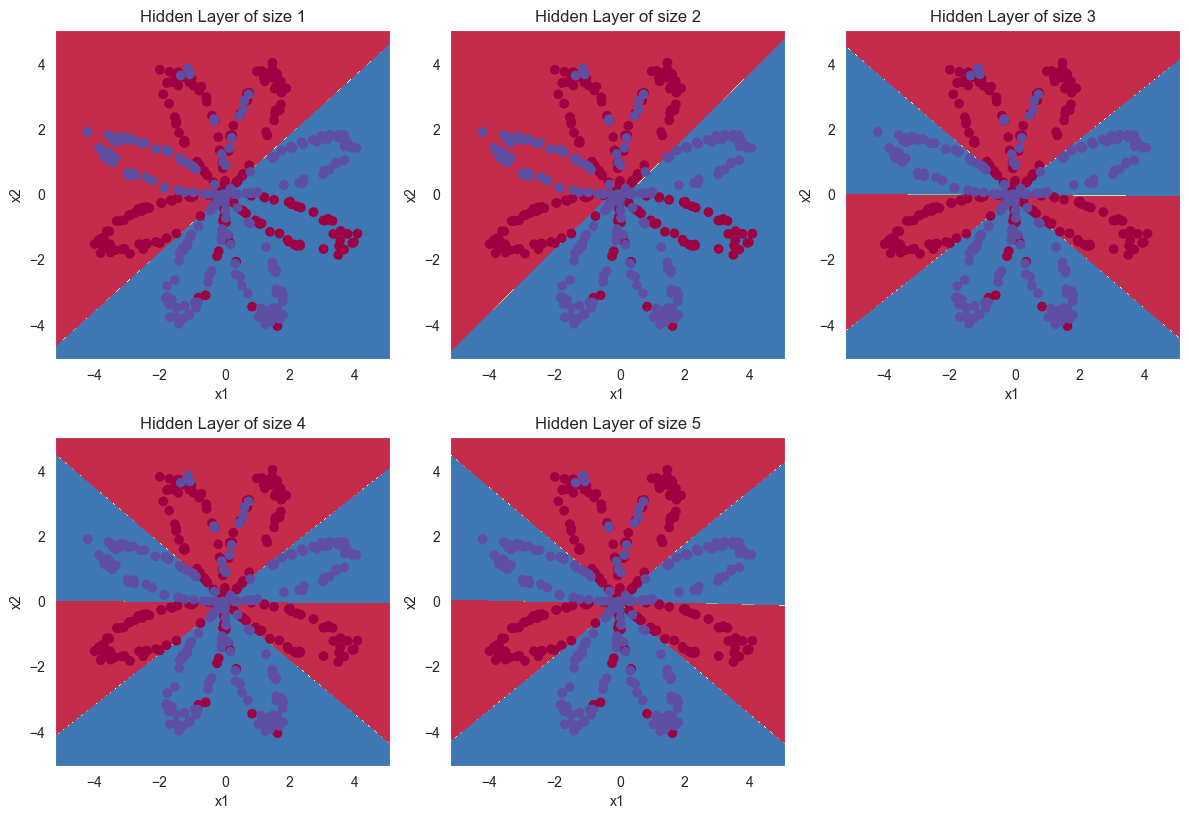

In [62]:
# We can see how the accuracy changes as we increase the number
# of units in the hidden layer.
plt.figure(figsize=(12, 16))
hidden_layer_sizes = [1, 2, 3, 4, 5]

# Plot each decision boundary with a different # of units for the hidden layer.
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(4, 3, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, max_iter= 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = accuracy_score(Y.ravel(), predictions.ravel())
    print (f"Accuracy for {n_h} hidden units: {accuracy*100} %")
    plt.tight_layout()

# What we can take away from this is Neural Networks can perform much, much better than simple LR
# when the data is not linearly separable.